# Vehicle Tracking

### Step1: make a list of images to read in

In [47]:
import os
import glob
# images are divided up into vehicle and non-vehicles folders (each of which contains sub folders)
# Fiest locate vehicle images
basedir = 'vehicles/'
# Different folders represent diffrent sources for images e.g. GTI, Kitti, generated by me
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Vehicle images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'¥n')

# Do the same thing for non-vehicle images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+'¥n')

Number of Vehicle images found: 8792
Number of Non-Vehicle Images found: 8968


In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

### Histogram of Oriented Gradients (HOG)

In [49]:
def hog_feature(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Convert size (All Color channel)

In [50]:
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((color1, color2, color3))

### Color Histgram

In [51]:
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0],bins=nbins)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins)
    # Concatenate the histogram into a single feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0], channel3_hist[0]))
    return hist_features

### Combine them

In [52]:
def extract_features(
    imgs, color_space='RGB', spatial_size=(32,32), hist_bins=32, orient=9, pix_per_cell=8,
    cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True
):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(hog_feature(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = hog_feature(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Slide window

In [53]:
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(
    img, x_start_stop=[None, None], y_start_stop=[None, None], 
    xy_window=(64, 64), xy_overlap=(0.5, 0.5)
):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window position to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Caluculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
        
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # return the list of windows
    return window_list

### draw

In [54]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy wigh boxes drawn
    return imcopy

### Extract feature from single image

In [55]:
def single_img_features(
    img, color_space='RGB', spatial_size=(32,32), hist_bins=32, orient=9,
    pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True,
    hist_feat=True, hog_feat=True, vis=False
):
    #1) Define an empty list to receive features
    img_features = [ ]
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    #3) Compute spatial features if falg is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if falg is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == "ALL":
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(hog_feature(
                    feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,
                    vis=False, feature_vec=True
                ))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = hog_feature(
                    feature_image[:,:,hog_channel], orient,
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True
                )
            else:
                hog_features = hog_feature(
                    feature_image[:,:,hog_channel], orient,
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True
                )
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

### Search windows

In [56]:
def search_windows(
    img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
    hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2,
    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True
):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window rom original image
        test_img = cv2.resize(
            img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)
        )
        #4) Extract features for sthat window using single_img_features()
        features = single_img_features(
            test_img, color_space=color_space, spatial_size=spatial_size,
            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
            cell_per_block=cell_per_block, hog_channel=hog_channel,
            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
        )
        #5) Scale extraccted features to be fet to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### visualize

In [57]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### draw the image

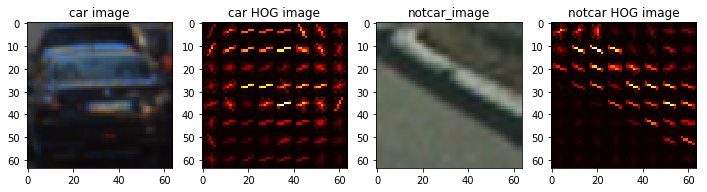

In [59]:
%matplotlib inline

# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32     # Number of histogram bins
spatial_feat = True # Statial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(
    car_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
    hog_feat=hog_feat, vis=True
)
notcar_features, notcar_hog_image = single_img_features(
    notcar_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
    hog_feat=hog_feat, vis=True
)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))#, dpi=80)
visualize(fig, 1, 4, images, titles)

### learn from image

In [13]:
# Define feature parameters
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
# n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(
    test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
    hog_feat=hog_feat
)
notcar_features = extract_features(
    test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
    hog_feat=hog_feat
)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state
)

print(
    'Using:', orient, 'orientation, ', pix_per_cell, 'pixels per cell,',
    cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and',
    spatial_size, 'spatial sampling'
)
print('Feature vector　length', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t,2), "Seconds to train SVC...")
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

288.27404403686523 Seconds to compute features...
Using: 9 orientation,  8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector　length 8460
87.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


### Search and Draw car box example

0.0 1.0
1.7444911003112793 seconds to process one image searching 100 windows
0.0 1.0
0.7294349670410156 seconds to process one image searching 100 windows
0.0 1.0
0.750917911529541 seconds to process one image searching 100 windows
0.0 1.0
1.0878939628601074 seconds to process one image searching 100 windows
0.0 1.0
1.2550668716430664 seconds to process one image searching 100 windows
0.0 1.0
1.0388031005859375 seconds to process one image searching 100 windows


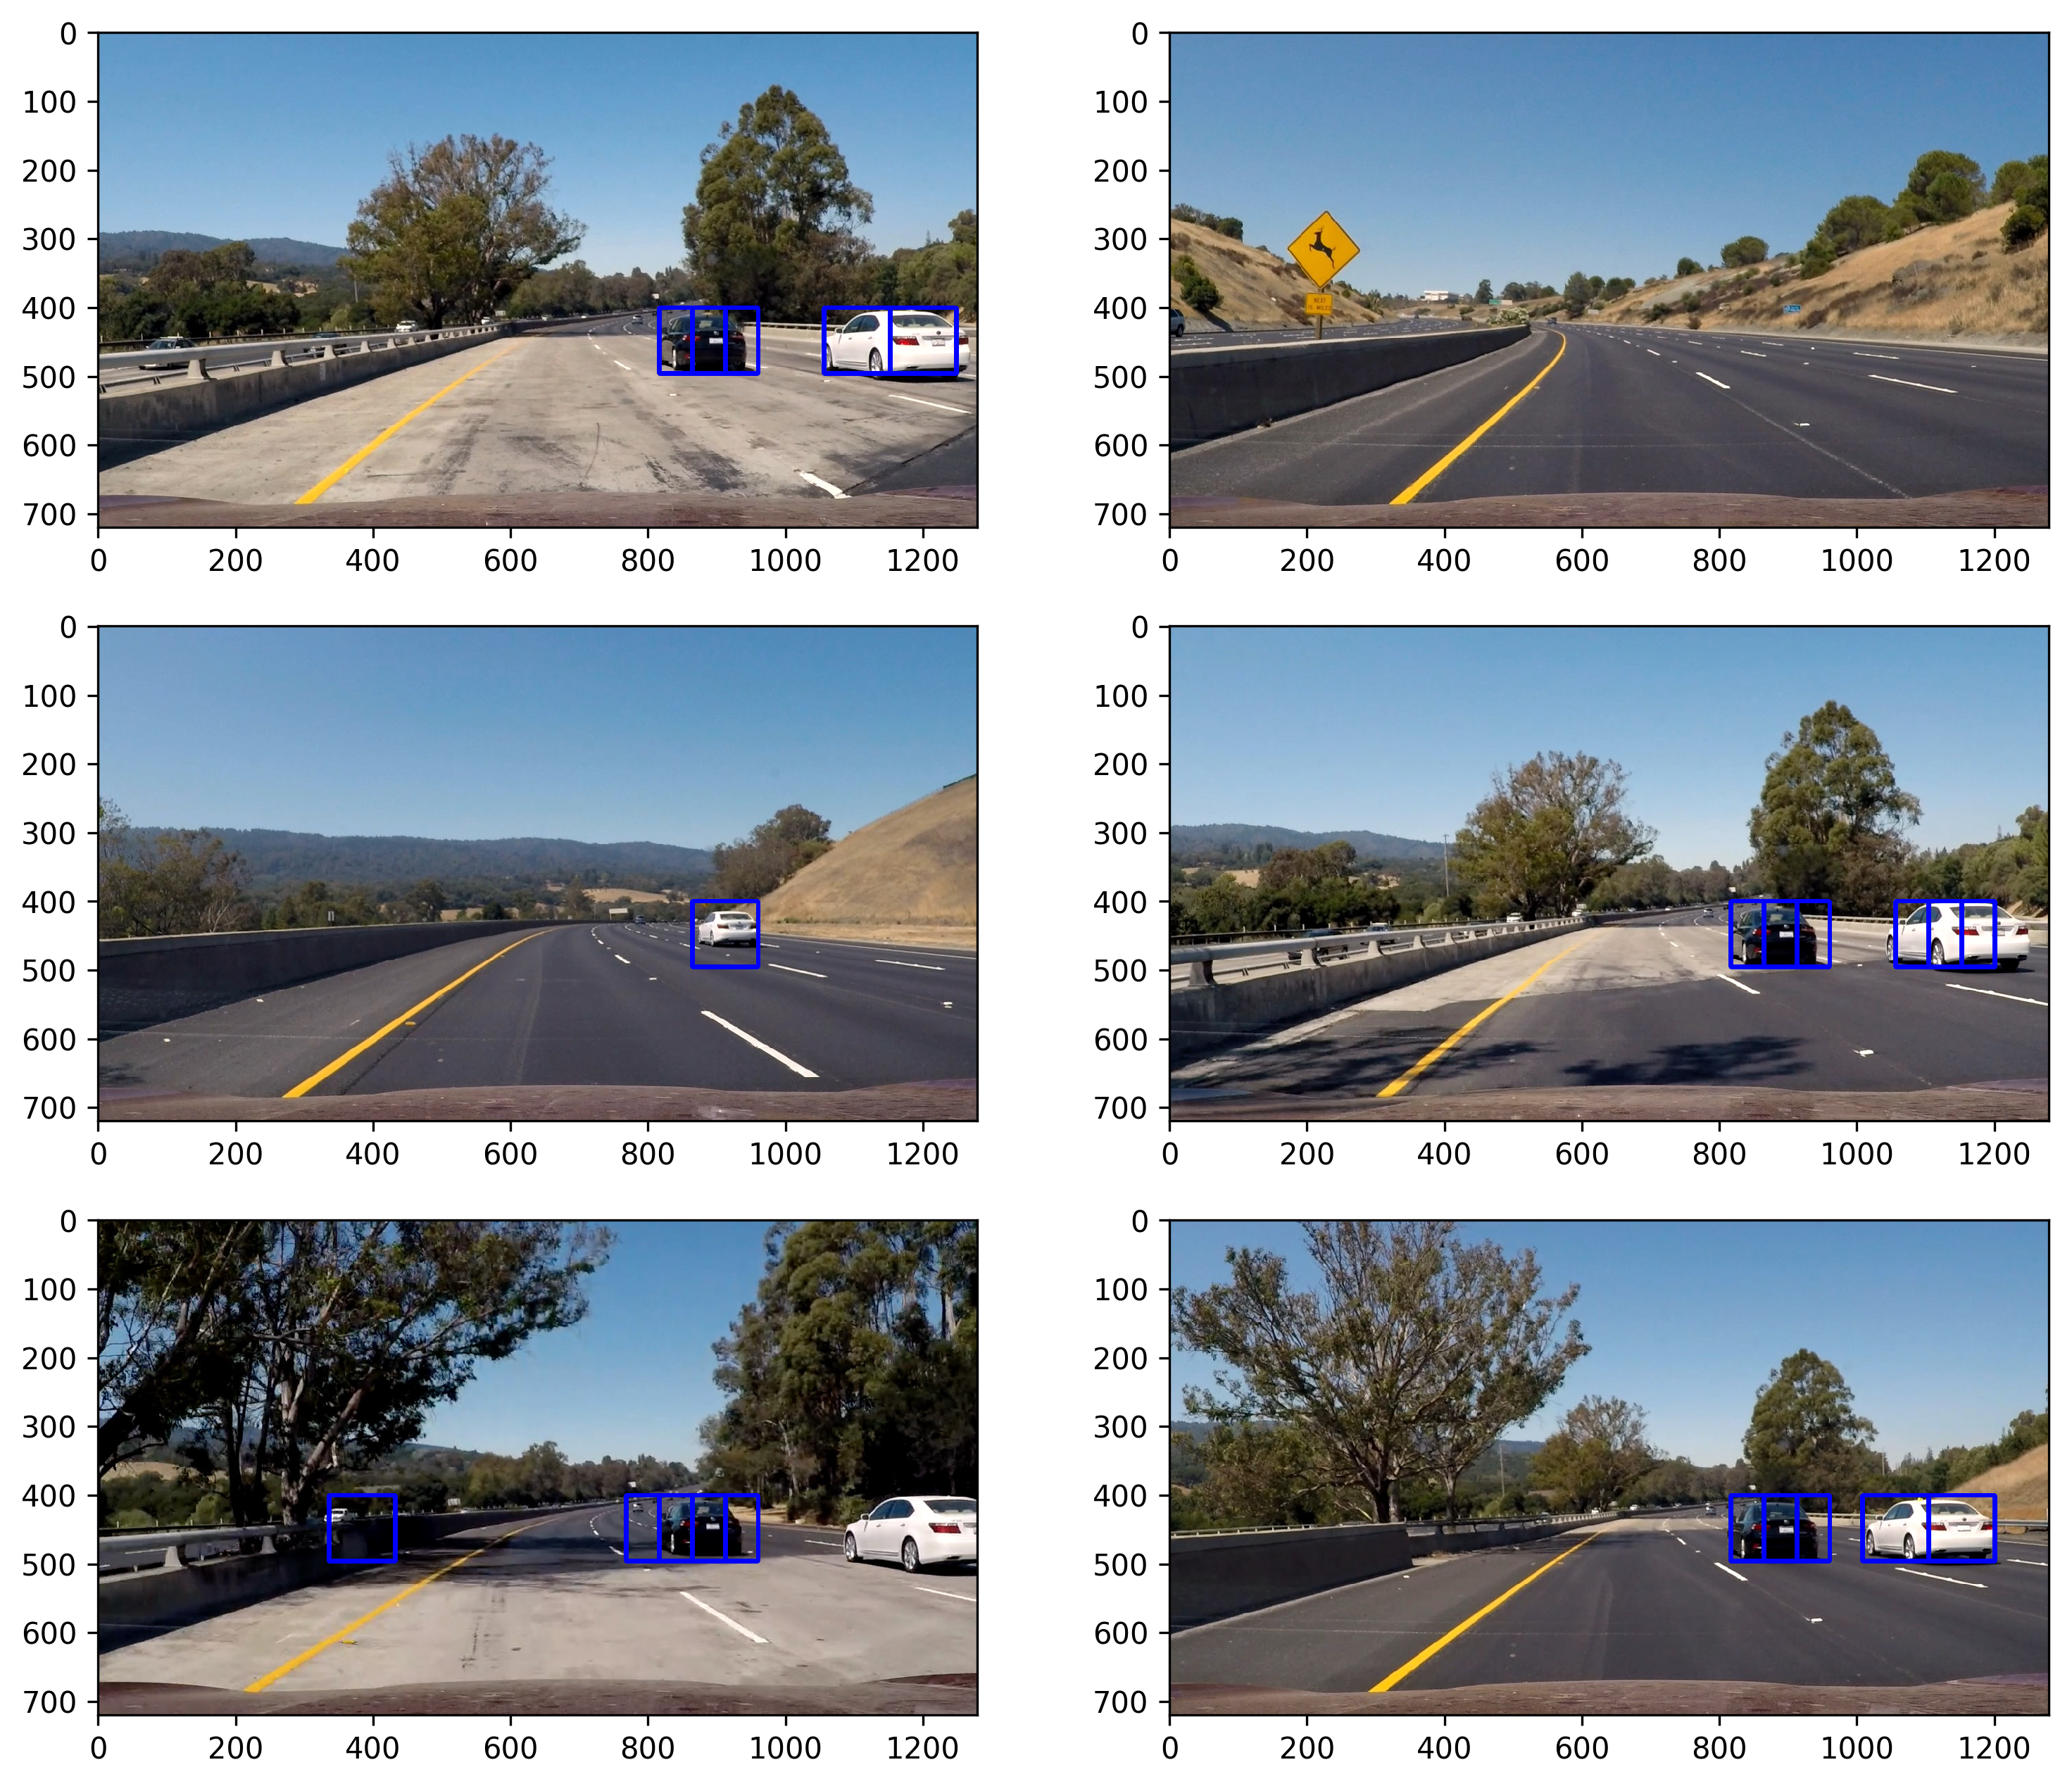

In [14]:
searchpath = 'images_video/vehicle_det_examples/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 # for jpg to png
    print(np.min(img), np.max(img))
    
    windows = slide_window(
        img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), 
        xy_overlap=(overlap, overlap)
    )
    hot_windows = search_windows(
        img, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
    )
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### draw heat map in example images

0.7892169952392578 seconds to run, total windows =  294
0.6837480068206787 seconds to run, total windows =  294
0.6630139350891113 seconds to run, total windows =  294
0.6148581504821777 seconds to run, total windows =  294
0.5818190574645996 seconds to run, total windows =  294
1.7578988075256348 seconds to run, total windows =  294


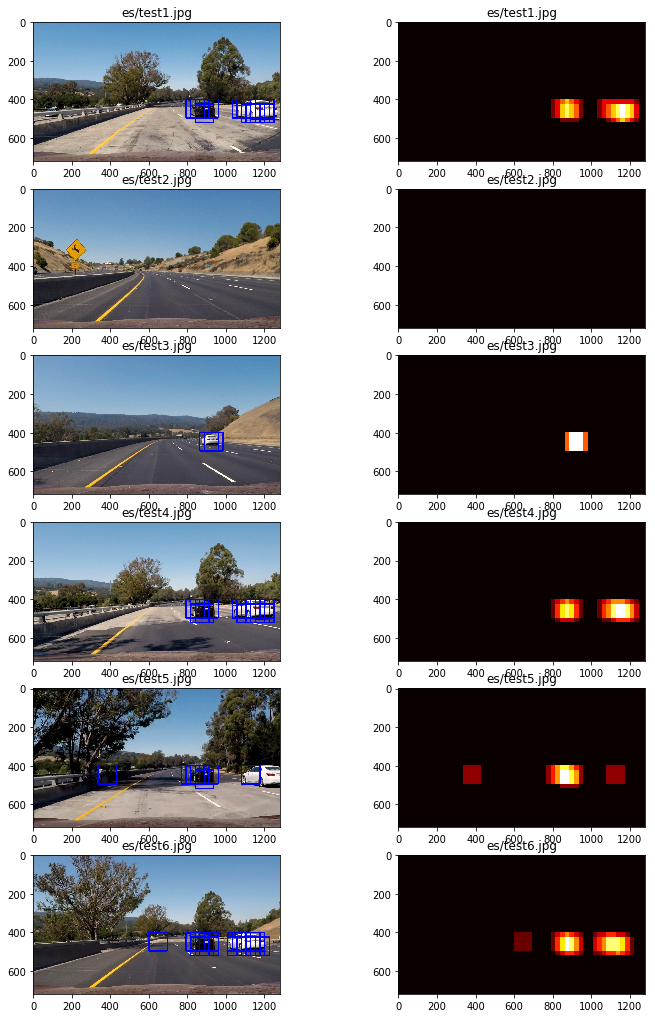

In [30]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart : ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks= (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    # nblocks_per_window = (window // pix_per_cell) - 1
    nblocks_per_window = window // pix_per_cell - cell_per_block + 1
    
    cells_per_step = 2  # Insted of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(
                ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64)
            )
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            )
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255), thickness=6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    print(time.time()-t, 'seconds to run, total windows = ', count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    #heatmap = 255*heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

### Heat map of the found cars

In [37]:
def find_cars(img, scale):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks= (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    # nblocks_per_window = (window // pix_per_cell) - 1
    nblocks_per_window = window // pix_per_cell - cell_per_block + 1
    
    cells_per_step = 2  # Insted of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):    
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(
                ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64)
            )
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            )
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255), thickness=6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

### test find car

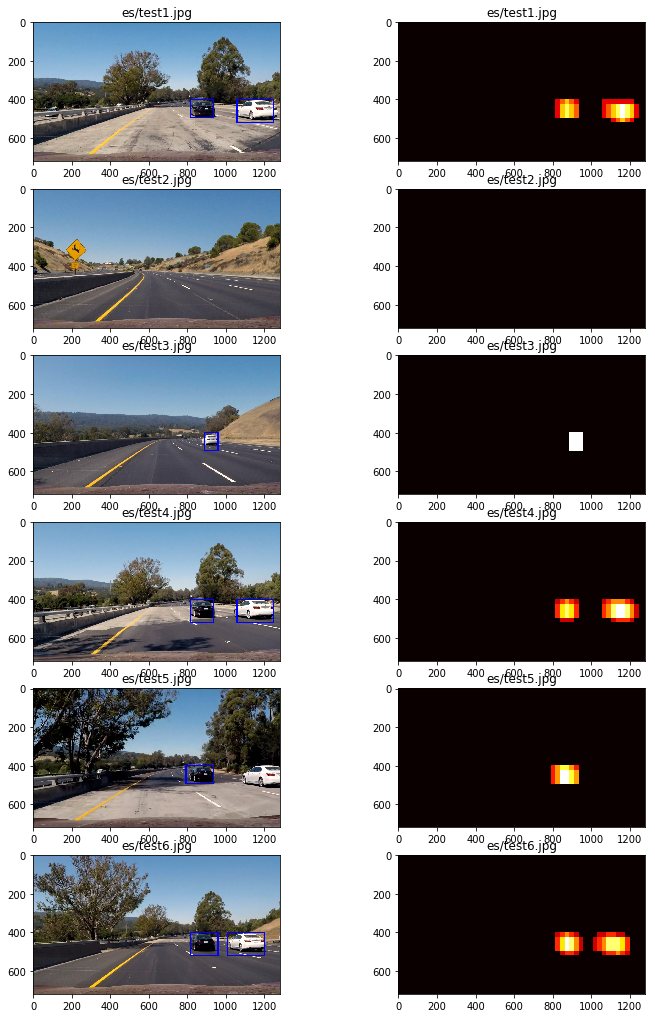

In [61]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    apply_threshold(heat_map, 1)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

### Output the Movie

In [62]:
def process_image(img):
    outimg, heat_map = find_cars(img, scale)
    apply_threshold(heat_map, 1)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
#clip = VideoFileClip("test_video.mp4")
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [16:49<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output)